# Setup the Env

In [2]:
import sys
import os

import sagemaker
from sagemaker import get_execution_role

# Add the parent directory to the sys.path
sys.path.insert(0, os.path.abspath(".."))

# Define IAM role
role = get_execution_role()
role

# Establish S3 bucket connection
import boto3

s3 = boto3.client("s3")
bucket = "capstone-bucket-4-friends"

# Take a look at current dir
print(os.getcwd())

from file_utilities import s3_download

/home/sagemaker-user/capstone-2024-summer/src/rachel


# Import Libraries

In [3]:
# standard libraries
import pickle
import numpy as np
import pandas as pd

# visualization
import matplotlib.pyplot as plt
#!pip install seaborn -q
import seaborn as sns

# model
import tensorflow as tf

# cosine
from scipy.spatial.distance import pdist, squareform

2024-07-25 03:29:47.866261: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Load Dataset

In [4]:
with open('/home/sagemaker-user/capstone-2024-summer/data/crsp_rachel_dict.pkl', 'rb') as file:
  merged_dict = pickle.load(file)

In [5]:
train_numerical_x = merged_dict['train_dict']['numerical_x']
train_categorical_x = merged_dict['train_dict']['categorical_x']
train_y = merged_dict['train_dict']['y']

print("---- training data ----")
print("--> num_numerical_features:", len(train_numerical_x.keys()))
for key in train_numerical_x.keys():
  print(key, train_numerical_x[key].shape)
print("--> num_categorical_features:", len(train_categorical_x.keys()))
for key in train_categorical_x.keys():
  print(key, train_categorical_x[key].shape)
print("--> target_shape:", train_y['y'].shape)

---- training data ----
--> num_numerical_features: 19
return_scaled (594309, 128, 1)
shares_outstanding_scaled (594309, 128, 1)
num_trades_scaled (594309, 128, 1)
volume_scaled (594309, 128, 1)
close_price_scaled (594309, 128, 1)
market_cap_scaled (594309, 128, 1)
volatility_7_scaled (594309, 128, 1)
sector_weighted_avg_return_scaled (594309, 128, 1)
sector_simple_avg_return_scaled (594309, 128, 1)
day_of_week_x (594309, 128, 1)
day_of_week_y (594309, 128, 1)
day_of_month_x (594309, 128, 1)
day_of_month_y (594309, 128, 1)
day_of_year_x (594309, 128, 1)
day_of_year_y (594309, 128, 1)
month_of_year_x (594309, 128, 1)
month_of_year_y (594309, 128, 1)
week_of_year_x (594309, 128, 1)
week_of_year_y (594309, 128, 1)
--> num_categorical_features: 4
permno_id (594309, 1)
company_name (594309, 1)
primary_exchange (594309, 1)
naics_sector (594309, 1)
--> target_shape: (594309, 1)


In [6]:
val_numerical_x = merged_dict['val_dict']['numerical_x']
val_categorical_x = merged_dict['val_dict']['categorical_x']
val_y = merged_dict['val_dict']['y']

print("---- validation data ----")
print("--> num_numerical_features:", len(val_numerical_x.keys()))
for key in val_numerical_x.keys():
  print(key, val_numerical_x[key].shape)
print("--> num_categorical_features:", len(val_categorical_x.keys()))
for key in val_categorical_x.keys():
  print(key, val_categorical_x[key].shape)
print("--> target_shape:", val_y['y'].shape)

---- validation data ----
--> num_numerical_features: 19
return_scaled (133650, 128, 1)
shares_outstanding_scaled (133650, 128, 1)
num_trades_scaled (133650, 128, 1)
volume_scaled (133650, 128, 1)
close_price_scaled (133650, 128, 1)
market_cap_scaled (133650, 128, 1)
volatility_7_scaled (133650, 128, 1)
sector_weighted_avg_return_scaled (133650, 128, 1)
sector_simple_avg_return_scaled (133650, 128, 1)
day_of_week_x (133650, 128, 1)
day_of_week_y (133650, 128, 1)
day_of_month_x (133650, 128, 1)
day_of_month_y (133650, 128, 1)
day_of_year_x (133650, 128, 1)
day_of_year_y (133650, 128, 1)
month_of_year_x (133650, 128, 1)
month_of_year_y (133650, 128, 1)
week_of_year_x (133650, 128, 1)
week_of_year_y (133650, 128, 1)
--> num_categorical_features: 4
permno_id (133650, 1)
company_name (133650, 1)
primary_exchange (133650, 1)
naics_sector (133650, 1)
--> target_shape: (133650, 1)


# Prepare the data for modeling

### Train

In [7]:
training_features = np.concatenate(list(train_numerical_x.values()), axis=-1)
training_features.shape

(594309, 128, 19)

In [8]:
training_permno = train_categorical_x['permno_id']
training_cnam = train_categorical_x['company_name']
training_pxch = train_categorical_x['primary_exchange']
training_sctr = train_categorical_x['naics_sector']

training_permno.shape

(594309, 1)

In [9]:
training_y = train_y['y']

training_y.shape

(594309, 1)

### Val

In [10]:
validation_features = np.concatenate(list(val_numerical_x.values()), axis=-1)
validation_features.shape

(133650, 128, 19)

In [11]:
validation_permno = val_categorical_x['permno_id']
validation_cnam = val_categorical_x['company_name']
validation_pxch = val_categorical_x['primary_exchange']
validation_sctr = val_categorical_x['naics_sector']

validation_permno.shape

(133650, 1)

In [12]:
validation_y = val_y['y']

validation_y.shape

(133650, 1)

# Define visualization function to visualize the training progression

In [13]:
def visualize(model_history):
  fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,5))
  # visualize the loss
  axes[0].plot(model_history.history['loss'], color='purple', label='train_losses')
  axes[0].plot(model_history.history['val_loss'], color='orange', label='val_losses')
  axes[0].set_xlabel('Epoch')
  axes[0].set_ylabel('Loss')
  axes[0].set_title('Loss Progression')
  axes[0].legend()

  # visualize the RMSE
  axes[1].plot(model_history.history['root_mean_squared_error'], color='purple', label='train_RMSE')
  axes[1].plot(model_history.history['val_root_mean_squared_error'], color='orange', label='val_RMSE')
  axes[1].set_xlabel('Epoch')
  axes[1].set_ylabel('RMSE')
  axes[1].set_title('RMSE Progression')
  axes[1].legend()

  plt.show()

# Build the model

In [14]:
EMBED_DIM = 200

In [15]:
def build_model(features,
                permno_features,
                initial_learning_rate=0.001,
                decay_steps=1000,
                decay_rate=0.96,
                attn_hidden=[128,64,32],
                embed_hidden=[64,32],
                hidden=[64,32],
                dropout=0.2):

  tf.keras.backend.clear_session()

  # set return features input layer
  return_features = tf.keras.layers.Input(shape=(features.shape[1],features.shape[2]), name='return_features') #[batch_size, num_days, num_features]

  # set permno features input layer
  permnos = tf.keras.layers.Input(shape=(1,), dtype=tf.string, name='permnos')
  permno_binned = tf.keras.layers.StringLookup(vocabulary=np.unique(permno_features))(permnos)
  permno_embeddings = tf.keras.layers.Embedding(input_dim=(len(np.unique(permno_features))+1), output_dim=EMBED_DIM, input_length=1, name='embeddings')(permno_binned) #[batch_size, num_permno, embed_dim]

  # prepare for attention layers
  attention_features = return_features

  # add attention layers
  attention_features = tf.keras.layers.MultiHeadAttention(key_dim=4, num_heads=2)(attention_features, attention_features)

  # flatten the output of the previous layers first to prepare for fully connected layers
  attention_features = tf.keras.layers.Flatten()(attention_features) #[batch_size, num_days * num_features]

  # add dense layers
  for i, size in enumerate(attn_hidden):
    attention_features = tf.keras.layers.Dense(size, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.02), name=f'return_dense_{i}')(attention_features)
    attention_features = tf.keras.layers.Dropout(dropout)(attention_features)

  # prepare for attention layers
  attention_permnos = permno_embeddings

  # add attention layers
  attention_permnos = tf.keras.layers.MultiHeadAttention(key_dim=4, num_heads=2)(attention_permnos, attention_permnos)

  # flatten the embedding features to prepare for dense layers
  attention_permnos = tf.keras.layers.Flatten()(attention_permnos) #[batch_size, num_permno * embed_dim]

  # add dense layers
  for i, size in enumerate(embed_hidden):
    attention_permnos = tf.keras.layers.Dense(size, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.02), name=f'embed_dense_{i}')(attention_permnos)
    attention_permnos = tf.keras.layers.Dropout(dropout)(attention_permnos)

  # concatenate the return and permno features
  features = tf.keras.layers.Concatenate(name='concat')([attention_features, attention_permnos])

  # add final fully connected layers
  for i, size in enumerate(hidden):
    features = tf.keras.layers.Dense(size, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.02), name=f'dense_{i}')(features)
    features = tf.keras.layers.Dropout(dropout)(features)

  # output layer
  outputs = tf.keras.layers.Dense(
      units=1,
      name='outputs',
      activation=None)(features)

  # build model and print summary
  model = tf.keras.Model(inputs=[permnos, return_features],
                          outputs=outputs,
                          name='model')

  print(model.summary())

  # define exponential delay LR
  lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
      initial_learning_rate=initial_learning_rate,
      decay_steps=decay_steps,
      decay_rate=decay_rate,
      staircase=True
  )

  # compile model
  model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule),
              loss=tf.keras.losses.MeanAbsoluteError(),
              metrics=tf.keras.metrics.RootMeanSquaredError())

  return model

## Train the model

In [16]:
callback = tf.keras.callbacks.EarlyStopping(
    monitor="val_root_mean_squared_error",
    patience=10,
    restore_best_weights=True,
    start_from_epoch=30,
)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 return_features (InputLaye  [(None, 128, 19)]            0         []                            
 r)                                                                                               
                                                                                                  
 permnos (InputLayer)        [(None, 1)]                  0         []                            
                                                                                                  
 multi_head_attention (Mult  (None, 128, 19)              651       ['return_features[0][0]',     
 iHeadAttention)                                                     'return_features[0][0]']     
                                                                                              

2024-07-25 03:30:26.423340: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 5781437952 exceeds 10% of free system memory.


9287/9287 [==============================] - 204s 22ms/step - loss: 3.7786 - root_mean_squared_error: 0.0943 - val_loss: 0.1064 - val_root_mean_squared_error: 0.0601
Epoch 2/10
9287/9287 [==============================] - 199s 21ms/step - loss: 0.0657 - root_mean_squared_error: 0.0755 - val_loss: 0.0459 - val_root_mean_squared_error: 0.0594
Epoch 3/10
9287/9287 [==============================] - 199s 21ms/step - loss: 0.0562 - root_mean_squared_error: 0.0750 - val_loss: 0.0446 - val_root_mean_squared_error: 0.0593
Epoch 4/10
9287/9287 [==============================] - 199s 21ms/step - loss: 0.0552 - root_mean_squared_error: 0.0748 - val_loss: 0.0439 - val_root_mean_squared_error: 0.0591
Epoch 5/10
9287/9287 [==============================] - 198s 21ms/step - loss: 0.0548 - root_mean_squared_error: 0.0748 - val_loss: 0.0436 - val_root_mean_squared_error: 0.0591
Epoch 6/10
9287/9287 [==============================] - 197s 21ms/step - loss: 0.0544 - root_mean_squared_error: 0.0747 - val_

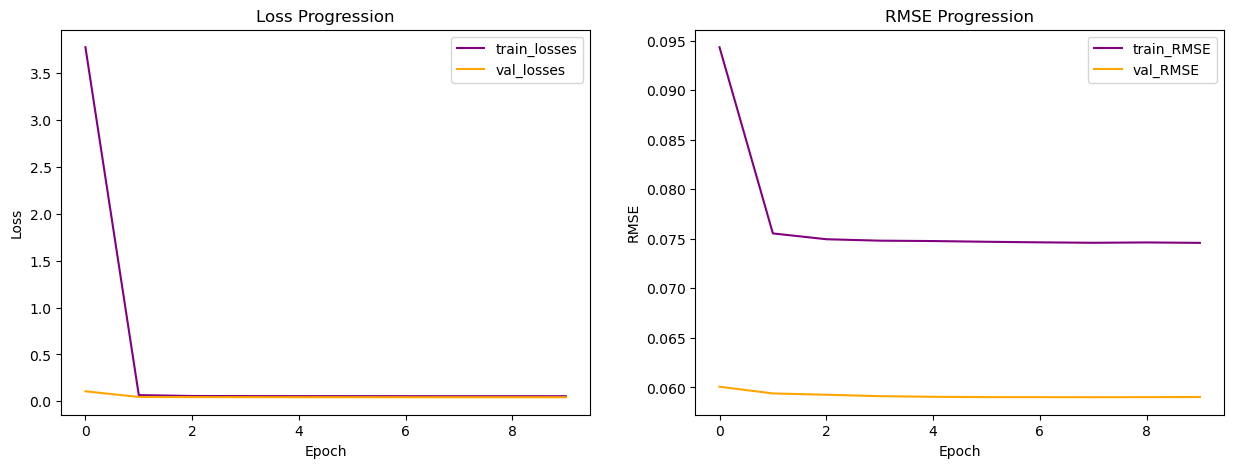

In [17]:
model = build_model(training_features,
                    training_permno,
                    initial_learning_rate=0.00002,
                    decay_steps=1000,
                    decay_rate=0.96,
                    attn_hidden=[256,128,64],
                    embed_hidden=[128,64],
                    hidden=[1024],
                    dropout=0.3)

# get original embeddings
embeddings_untrained = model.get_layer('embeddings').get_weights()[0]

history = model.fit(
   x=[training_permno, training_features],
   y=training_y,
   epochs=10,
   validation_data=(
      [validation_permno, validation_features],
      validation_y
   ),
   batch_size=64,
   callbacks=[callback],
   verbose=1)

# get trained embeddings
embeddings_trained = model.get_layer('embeddings').get_weights()[0]

visualize(history)

# Generate overall predictions & visualize the results

In [18]:
training_prediction = model.predict([training_permno, training_features])
validation_prediction = model.predict([validation_permno, validation_features])

2024-07-25 04:03:42.817630: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 5781437952 exceeds 10% of free system memory.


4177/4177 [==============================] - 20s 5ms/step


In [19]:
def visualize_results(y_true, y_pred):
  plt.figure(figsize=(10, 4))

  # Plot the true values
  plt.plot(y_true, label='True Value')
  plt.plot(y_pred, label='Predicted Value')

  # Labels and title
  plt.xlabel('Horizon')
  plt.ylabel('Scaled_Return')
  plt.title('Predictions vs. True Values')
  plt.legend()
  plt.show()

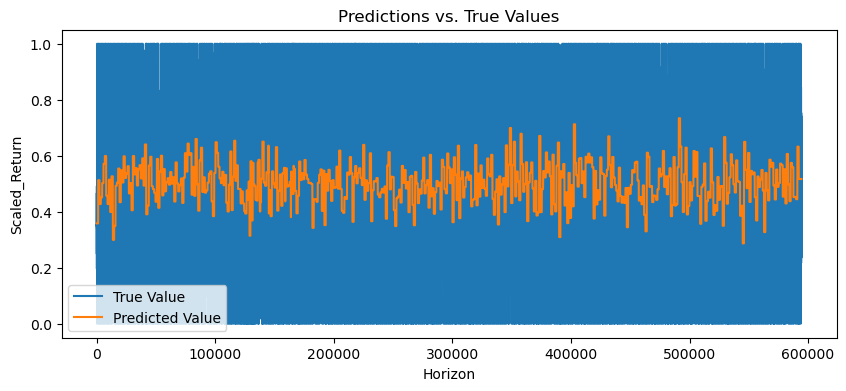

In [20]:
visualize_results(training_y, training_prediction)

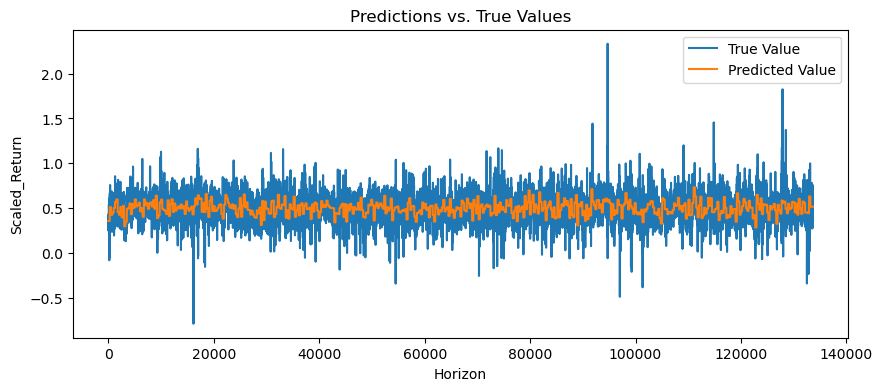

In [21]:
visualize_results(validation_y, validation_prediction)

# Look at the embeddings

In [22]:
embeddings_untrained.shape

(540, 200)

In [23]:
embeddings_untrained[1:][:2]

array([[-0.01729559,  0.02514254,  0.01220292, -0.03949434, -0.02021184,
        -0.03043032, -0.01463493,  0.02903774, -0.04576538, -0.02704657,
         0.00551366, -0.00841666, -0.02605331,  0.02623777, -0.0170926 ,
        -0.02956569, -0.01179545, -0.00292213, -0.04731977,  0.00096109,
         0.04814568, -0.03970609, -0.01276826, -0.0247339 ,  0.04219191,
        -0.04973003, -0.04606321, -0.04735959, -0.04806583,  0.03808162,
        -0.01163705,  0.01676972, -0.00608152,  0.01747055, -0.00479641,
        -0.04191685, -0.04092406,  0.02429989, -0.01039501,  0.01708085,
        -0.02438725, -0.03763204,  0.01295665,  0.02870143, -0.0422729 ,
         0.01472786,  0.01572916,  0.00318072, -0.00895529,  0.01505494,
         0.01580573,  0.01713321, -0.04355519,  0.04198853,  0.02173067,
        -0.03396158, -0.03842106,  0.0020473 ,  0.01065405,  0.03285631,
         0.0007952 ,  0.03920971, -0.0116321 , -0.0165324 ,  0.00137694,
        -0.01106218, -0.00452315, -0.01189516,  0.0

In [24]:
embeddings_trained[1:][:2]

array([[-0.06814542, -0.02632802, -0.03492404,  0.01123339, -0.0705911 ,
         0.02047657,  0.0333536 ,  0.08125836, -0.09637279,  0.02178104,
         0.05684534, -0.05892703,  0.02020837, -0.02387941,  0.03049536,
         0.02007179,  0.03849598,  0.04874139, -0.09410468, -0.04912543,
        -0.00172084,  0.01074699, -0.06402589, -0.07412216,  0.08524372,
        -0.00095343, -0.09684835,  0.00336765, -0.0025265 , -0.00651349,
        -0.05974029,  0.06104094,  0.04116484,  0.06654231,  0.046074  ,
        -0.09121545,  0.01004212,  0.07497105,  0.01966207, -0.03396624,
         0.020813  ,  0.01035342, -0.0333488 , -0.01851975, -0.08447608,
        -0.03504287, -0.03349503, -0.04735588, -0.05711791,  0.06535292,
        -0.03415133, -0.03336097,  0.0066211 , -0.00394061,  0.07088544,
        -0.08331116, -0.08737072, -0.04756908,  0.06128911,  0.07091003,
         0.04663889, -0.01060777,  0.03800111, -0.06553421,  0.05228827,
         0.03672848,  0.04499566, -0.06152045, -0.0

Ignore the 1st embedding element, we have the embeddings corresponding to each permno starting from the 2nd embedding element

# Run cosine similarity on the embeddings

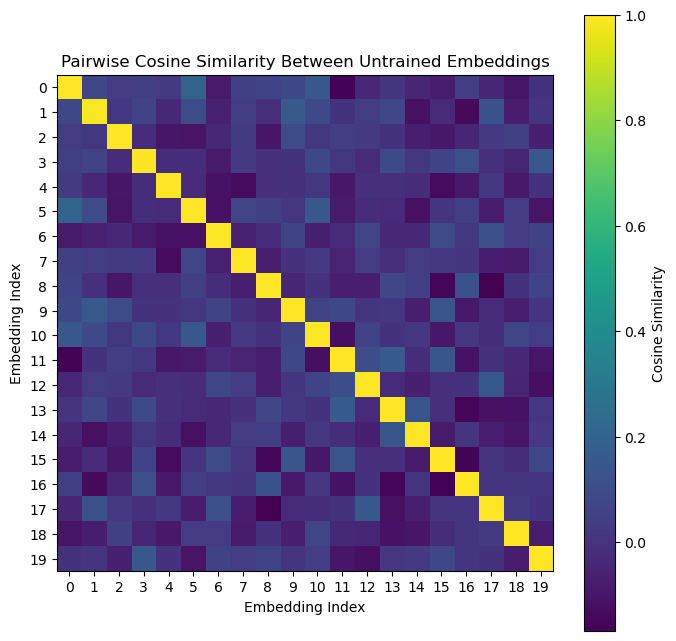

In [27]:
num_permnos = len(np.unique(training_permno))

# Calculate pairwise cosine similarity
cosine_distances = pdist(embeddings_untrained[1:], metric='cosine')
cosine_similarities = 1 - squareform(cosine_distances)

subset_distances = pdist(embeddings_untrained[1:21], metric='cosine')
subset = 1 - squareform(subset_distances)

# Plot the cosine similarity matrix
plt.figure(figsize=(8, 8))
plt.imshow(subset, cmap='viridis')
plt.colorbar(label='Cosine Similarity')
plt.title('Pairwise Cosine Similarity Between Untrained Embeddings')
plt.xlabel('Embedding Index')
plt.ylabel('Embedding Index')
plt.xticks(ticks=np.arange(20), labels=np.arange(20))
plt.yticks(ticks=np.arange(20), labels=np.arange(20))
plt.show()

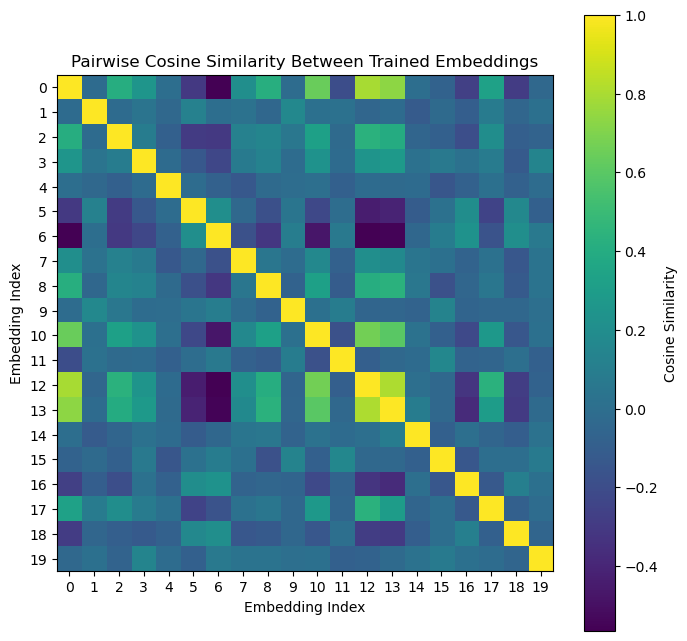

In [28]:
num_permnos = len(np.unique(training_permno))

# Calculate pairwise cosine similarity
cosine_distances = pdist(embeddings_trained[1:], metric='cosine')
cosine_similarities = 1 - squareform(cosine_distances)

subset_distances = pdist(embeddings_trained[1:21], metric='cosine')
subset = 1 - squareform(subset_distances)

# Plot the cosine similarity matrix
plt.figure(figsize=(8, 8))
plt.imshow(subset, cmap='viridis')
plt.colorbar(label='Cosine Similarity')
plt.title('Pairwise Cosine Similarity Between Trained Embeddings')
plt.xlabel('Embedding Index')
plt.ylabel('Embedding Index')
plt.xticks(ticks=np.arange(20), labels=np.arange(20))
plt.yticks(ticks=np.arange(20), labels=np.arange(20))
plt.show()

# Put the permnos, embeddings, and, cosine similarities into a dict

In [29]:
results = {}

results["permno_id"] = np.unique(training_permno)
results["embeddings"] = embeddings_trained[1:]
results["cosine"] = cosine_similarities

In [30]:
display(results["permno_id"].shape)
display(results["embeddings"].shape)
display(results["cosine"].shape)

(539,)

(539, 200)

(539, 539)

In [31]:
results

{'permno_id': array(['10104', '10107', '10138', '10145', '10516', '10696', '11308',
        '11403', '11404', '11600', '11618', '11674', '11691', '11762',
        '11850', '11891', '11955', '12036', '12052', '12060', '12062',
        '12084', '12308', '12345', '12369', '12431', '12449', '12476',
        '12490', '12558', '12622', '12623', '12872', '13035', '13103',
        '13168', '13210', '13323', '13356', '13379', '13407', '13447',
        '13511', '13586', '13628', '13641', '13688', '13721', '13757',
        '13760', '13788', '13856', '13901', '13911', '13928', '13949',
        '13963', '13964', '14008', '14277', '14297', '14338', '14541',
        '14542', '14579', '14593', '14702', '14714', '14763', '14776',
        '14811', '14882', '14889', '14939', '15069', '15202', '15291',
        '15408', '15488', '15579', '15707', '15720', '15850', '15998',
        '16000', '16048', '16087', '16309', '16431', '16581', '16600',
        '16649', '16678', '16692', '16851', '16968', '17005', '1

# Sample 5 permnos to visualize the true values vs predictions

In [32]:
visualize_df = pd.DataFrame({'permno_id': training_permno.flatten(),
                             'true_y': training_y.flatten(),
                             'pred_y': training_prediction.flatten()})
visualize_df.head()

,permno_id,true_y,pred_y
0,10104,0.351361,0.358427
1,10104,0.378944,0.358427
2,10104,0.333136,0.358427
3,10104,0.336970,0.358427
4,10104,0.355310,0.358427


-------------------------------------------------- 10104 --------------------------------------------------


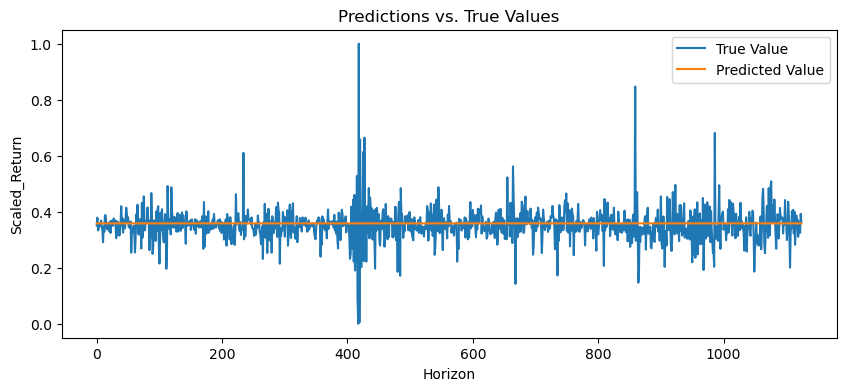


-------------------------------------------------- 10107 --------------------------------------------------


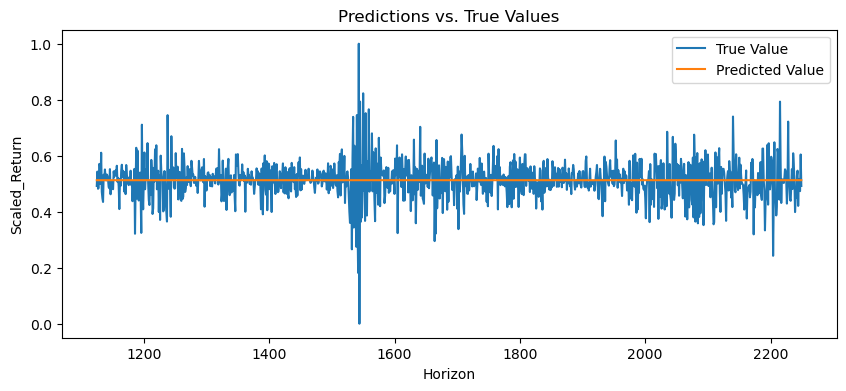


-------------------------------------------------- 10138 --------------------------------------------------


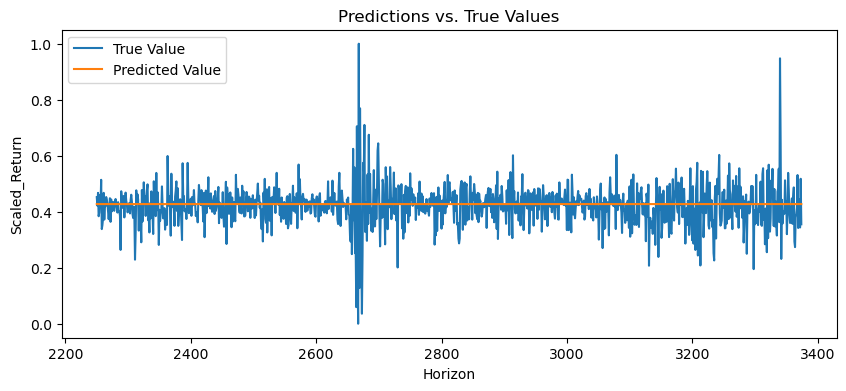


-------------------------------------------------- 10145 --------------------------------------------------


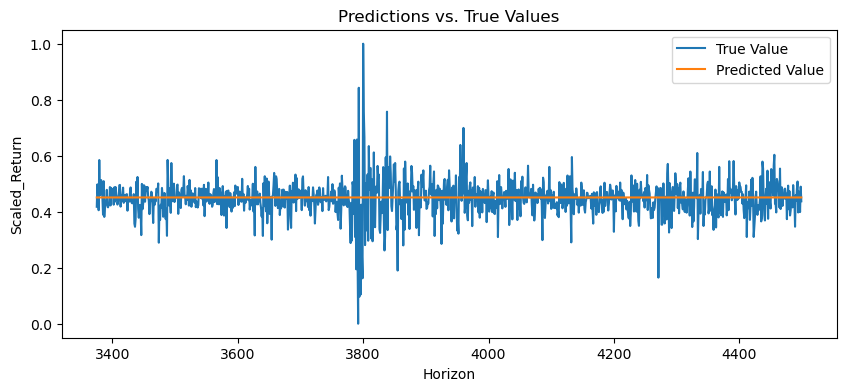


-------------------------------------------------- 10516 --------------------------------------------------


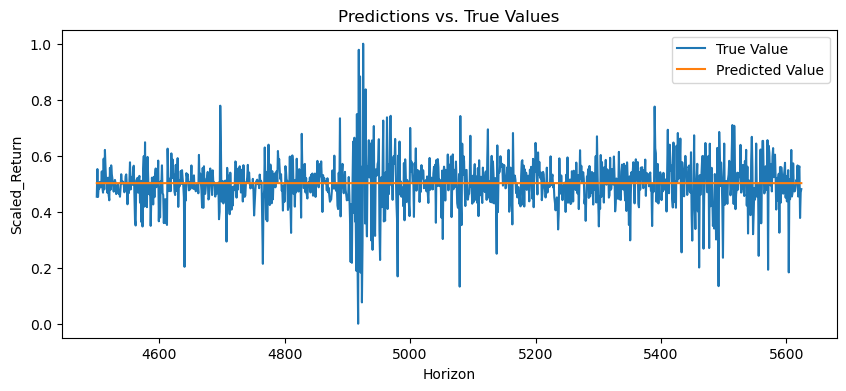

In [33]:
for permno in visualize_df['permno_id'].unique()[:5]:
  print("-"*50, permno, "-"*50)
  visualize_permno = visualize_df[visualize_df['permno_id'] == permno]
  visualize_results(visualize_permno['true_y'], visualize_permno['pred_y'])
  print()

# Save the trained embeddings & calculated cosine similarities to a pkl file

In [34]:
with open('/home/sagemaker-user/capstone-2024-summer/data/crsp_rachel_results_500.pkl', 'wb') as file:
  pickle.dump(results, file)

In [35]:
s3.upload_file(
    "/home/sagemaker-user/capstone-2024-summer/data/crsp_rachel_results_500.pkl",
    bucket,
    "CRSP/crsp_rachel_results_500.pkl",
)